In this notebook, we will explore word embeddings based on the news articles in the Brown Corpus. Note that the content is heavily borrowed from the official tensorflow tutorial: https://www.tensorflow.org/tutorials/word2vec

In [2]:
import numpy as np
import tensorflow as tf
%pylab inline
pylab.style.use('ggplot')
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# What are Word Embeddings?

Vector space models (VSMs) represent (embed) words in a continuous vector space where semantically similar words are mapped to nearby points ('are embedded nearby each other'). VSMs have a long, rich history in NLP, but all methods depend in some way or another on the Distributional Hypothesis, which states that words that appear in the same contexts share semantic meaning. 

Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).

Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model. 

Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets. 

# Noise-Contrastive Training

Neural probabilistic language models are traditionally trained using the maximum likelihood (ML) principle to maximize the probability of the next word (for "target") given the previous words (for "history") in terms of a softmax function.

$$\begin{align}
P(w_t | h) &= \text{softmax} (\text{score} (w_t, h)) \\
           &= \frac{\exp \{ \text{score} (w_t, h) \} }
             {\sum_\text{Word w' in Vocab} \exp \{ \text{score} (w', h) \} }
\end{align}$$


This yields a properly normalized probabilistic model for language modeling. However this is very expensive, because we need to compute and normalize each probability using the score for all other words in the current context , at every training step.

<img src="https://www.tensorflow.org/images/softmax-nplm.png" width="400", height="400" />

On the other hand, for feature learning in word2vec we do not need a full probabilistic model. The CBOW and skip-gram models are instead trained using a binary classification objective (logistic regression) to discriminate the real target words from imaginary (noise) words , in the same context. We illustrate this below for a CBOW model. For skip-gram the direction is simply inverted.

<img src="https://www.tensorflow.org/images/nce-nplm.png" width="400", height="400" />

Mathematically, the loss function is:

$$J_\text{NEG} = \log Q_\theta(D=1 |w_t, h) +  k \mathop{\mathbb{E}}_{\tilde w \sim P_\text{noise}} \left[ \log Q_\theta(D = 0 |\tilde w, h) \right]$$
    
     
Where $Q_{\theta}(D=1 | w, h)$ is the binary logistic regression probability under the model of seeing the word in the context in the dataset , calculated in terms of the learned embedding vectors . In practice we approximate the expectation by drawing contrastive words from the noise distribution (i.e. we compute a Monte Carlo average).

This objective is maximized when the model assigns high probabilities to the real words, and low probabilities to noise words. Technically, this is called Negative Sampling, and there is good mathematical motivation for using this loss function: The updates it proposes approximate the updates of the softmax function in the limit. But computationally it is especially appealing because computing the loss function now scales only with the number of noise words that we select, and not all words in the vocabulary. This makes it much faster to train. We will actually make use of the very similar noise-contrastive estimation (NCE) loss, for which TensorFlow has a handy helper function `tf.nn.nce_loss()`.

# Getting the Data

In [3]:
import nltk
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


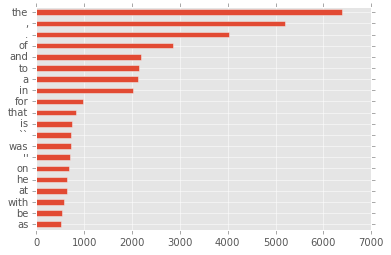

In [4]:
brown_words =  brown.words(categories=['news'])
lcase_words = [w.lower() for w in brown_words]

word_counts = pd.Series(lcase_words).value_counts()
word_counts.nlargest(20).sort_values().plot(kind='barh')

In [5]:
word_counts.count()

13112

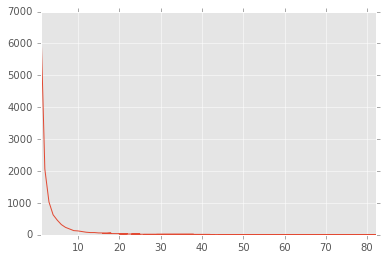

In [6]:
word_counts.value_counts().sort_values(ascending=False).plot()

so, the majority of the words are rare. There are only a small number of words that appear > 5 times.

In [7]:
word_counts[word_counts > 5].count()

2099

# Preprocessing

In the preprocessing step, we will convert all the words to lowercase and pack the sentences into a `pandas.Series`.

In [8]:
lcase_sents = []

for s in brown.sents(categories=['news']):
    lcase_sents.append([w.lower() for w in s])
    
lcase_sents = pd.Series(data=lcase_sents, name='sentences')

In [9]:
lcase_sents.head()

0    [the, fulton, county, grand, jury, said, frida...
1    [the, jury, further, said, in, term-end, prese...
2    [the, september-october, term, jury, had, been...
3    [``, only, a, relative, handful, of, such, rep...
4    [the, jury, said, it, did, find, that, many, o...
Name: sentences, dtype: object

The next step is to generate the (context, target) pairs from a given sentence for a given window size and skip size. 

In [10]:
def gen_context_target_pairs(sent, w_size=1, n_skip=1):
    """
    Convert each sentence (a list of words) to a DataFrame with two columns, 'context' and 'target' for the 
    skip-gram model. The DataFrame has one row for each possible target.
    
    Target is always a single word. For a given target, we build the context by taking the 
    `w_size` sized window centered on target and skipping `n_skip` words.
        
    Assumes each sentence has > w_size words.
    """
    w_length = 2 * w_size + 1
    # our context must have at least 1 word
    assert n_skip < w_length - 1
    
    # sent must have enough words
    assert len(sent) > w_length
    
    recs = []
    for i, w in enumerate(sent):
        if i < w_size or i + w_size + 1 > len(sent):
        # in this case, we don't have a full window
            continue
        else:
            full_context = sent[i-w_size:i] + sent[i+1:i+w_size+1]
            skip_context = random.choice(full_context, len(full_context) - n_skip)
            recs.append([skip_context, w])
            
    rec_df = pd.DataFrame.from_records(recs, columns=['context', 'target'])
    
    return rec_df

In [11]:
gen_context_target_pairs(lcase_sents[0])

,context,target
0,[the],fulton
1,[fulton],county
2,[jury],grand
3,[said],jury
4,[jury],said
5,[said],friday
6,[investigation],an
7,[an],investigation
8,[investigation],of
9,[of],atlanta's


Next, we replace every word in the corpus by a unique integer ID. We also choose a minimum frequency threshold for word frequencies to filter out rare words.

In [12]:
vocab_cache = word_counts.reset_index().reset_index()
vocab_cache.columns = ['word_id', 'word', 'count']

In [13]:
vocab_cache.head()

,word_id,word,count
0,0,the,6386
1,1,",",5188
2,2,.,4030
3,3,of,2861
4,4,and,2186


In [14]:
def remove_rare_words(v_cache, min_freq):
    """Returns the subset of words in v_cache where count >= min_freq."""
    new_cache = v_cache.loc[v_cache['count'] >= min_freq, :]
    return new_cache

In [15]:
def filter_by_vocabulary(sents, v_cache, w_size):
    """Filter list of sentences, `sent`, by words in `v_cache`.
    
    First remove all the words in each sentence that are not in `v_cache`. 
    Then keep sentences with more than 2*w_size+1 words.
    """
    processed_sents = []
    words_in_vocabulary = set(v_cache.word.values)
    min_sent_len = 2 * w_size + 1
    for s in sents:
        new_s = [w for w in s if w in words_in_vocabulary]
        
        if len(new_s) > min_sent_len:
            processed_sents.append(new_s)
            
    print('Number of sentences: before [%s], after [%s]' % (len(sents), len(processed_sents)))            
    return processed_sents

In [16]:
def map_to_int(context_pair_df, v_cache):
    """Take a context pair DataFrame and map the words to their integer IDs. The cache must be indexed by the word."""
    
    mapped_target = context_pair_df.target.apply(lambda w: v_cache.loc[w, 'word_id'])   
    mapped_context = context_pair_df.context.apply(lambda c: v_cache.loc[c, 'word_id'].values)   
    return pd.concat({'target': mapped_target, 'context': mapped_context}, axis=1)

In [18]:
from ipywidgets import FloatProgress
from IPython.display import display

def make_dataset(sents, v_cache, min_freq=5, w_size=1, n_skip=1):
    """
    Make a "dataset" suitable for data input into the TensorFlow skip-gram model.
    
    The "dataset" is a pandas DataFrame with the 'target' and 'context' columns as described above. Both are integers.
    The index is a global integer sentence sequence number.    
    """
    
    vocab_cache = remove_rare_words(v_cache, min_freq)
    sents = filter_by_vocabulary(sents, vocab_cache, w_size)
    vocab_cache = vocab_cache.set_index('word')
    
    pg = FloatProgress(min=1, max=len(sents), description='Preparing dataset...')
    display(pg)
    
    dfs = []
    
    for sent in sents:        
        word_df = gen_context_target_pairs(sent, w_size=w_size, n_skip=n_skip)
        mapped_df = map_to_int(word_df, vocab_cache)
        dfs.append(mapped_df)
        pg.value += 1
        
    pg.bar_style = 'success'
    pg.description = 'Done.'
    
    dfs = pd.concat(dfs, axis=0)
    dfs.index = np.arange(0, len(dfs))
    
    return vocab_cache, dfs

In [19]:
t_cache, dataset = make_dataset(lcase_sents, vocab_cache)

Number of sentences: before [4623], after [4324]


In [20]:
dataset.head()

,context,target
0,[136],816
1,[583],136
2,[136],583
3,[583],193
4,[226],23


# Build the TensorFlow Graph

In [21]:
vocabulary_size = len(t_cache)
embedding_size = 20
batch_size = len(dataset)
num_sampled = 10

targets = dataset.target.values.astype(np.int32)
contexts = np.atleast_2d(np.concatenate(dataset.context.values)).T.astype(np.int32)

In [25]:
tf.reset_default_graph()

embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0, 
                      dtype=np.float32, name='embeddings')
)

nce_weights = tf.Variable(
  tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / np.sqrt(embedding_size),
                      dtype=np.float32), name='nce_weights',
)

nce_biases = tf.Variable(tf.zeros([vocabulary_size], dtype=np.float32), name='nce_biases')

# For skip-gram, inputs are context
train_inputs = tf.placeholder(np.int32, shape=batch_size, name='train_inputs')

# For skip-gram, labels are source
train_labels = tf.placeholder(np.int32, shape=[batch_size, 1], name='train_labels')

embed = tf.nn.embedding_lookup(embeddings, train_inputs, name='embedding_lookup')

loss = tf.reduce_mean(
  tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocabulary_size), name='loss_function')

optimizer = tf.train.AdamOptimizer(learning_rate=0.015)
train_op = optimizer.minimize(loss)

50 33.554
100 38.0597
150 56.9548
200 46.7068
250 51.9693
300 17.7704
350 18.1955
400 14.4351
450 21.9909
500 10.3271
550 5.60234
600 25.8646
650 24.9049
700 38.2996
750 13.3007
800 13.6004
850 16.1978
900 14.9288
950 5.34754
1000 31.0527


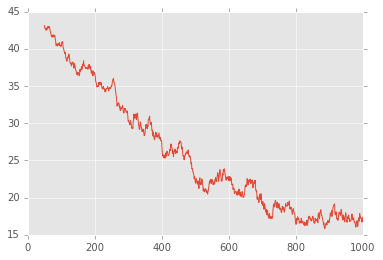

In [32]:
n_iters = 1000
feed_dict = {train_inputs: targets, train_labels: contexts}

train_pg = FloatProgress(min=1, max=n_iters, description='Training...')
display(train_pg)
losses = []

with tf.Session() as session:
    
    session.run(tf.global_variables_initializer())
    for i in range(1, n_iters+1):
        _, cur_loss = session.run([train_op, loss], feed_dict=feed_dict)
        train_pg.value += 1
        if i % 50 == 0:
            print(i, cur_loss)
        losses.append(cur_loss)
    train_pg.bar_style = 'success'
    train_pg.description = 'Done.'
    
    train_embeddings = embeddings.eval(session=session)
    
losses = pd.Series(losses)
losses.rolling(50).mean().plot()

In [33]:
# Make a dataframe with the embedding values
train_embeddings_df = pd.DataFrame(data=train_embeddings, index=t_cache.index)

In [35]:
train_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,,,,,,,,,,,,,,,,,,,,
the,-1.650545,-1.162983,-0.017489,-0.324192,0.640277,-0.573753,2.053180,0.775146,-1.373932,-2.625574,0.976826,-0.112552,0.420243,1.768553,0.092510,-0.134016,0.288391,1.238374,-0.143766,0.654485
",",-1.453982,-1.299749,0.357280,-0.136199,0.613661,-1.046776,1.371831,0.697540,-2.140992,-2.376004,0.848997,-0.687376,-0.140591,1.104857,0.388117,0.305596,-0.772756,1.669843,-0.278860,0.516430
.,-0.211236,-0.409714,-0.558326,-0.978886,-0.865600,-0.626222,-0.477406,0.329279,0.624149,0.435673,-0.242236,0.891192,-0.707488,0.994743,-0.940982,-0.322129,0.840361,-0.470073,0.101854,0.459007
of,-1.791834,-1.896137,-0.143705,-0.278482,-0.089646,-0.633101,1.633205,0.812748,-1.619202,-2.113307,1.655857,-0.133965,-0.186623,0.865129,0.553499,0.680412,-0.113432,1.224333,-0.915471,-0.098397
and,-1.049515,-1.681798,0.285650,0.062283,1.076554,-0.958528,1.670573,0.821198,-1.518790,-2.253498,1.477831,-0.997753,-0.259488,1.122732,0.042026,0.286847,0.337078,1.340894,-0.456722,0.090314


In [60]:
house_em = train_embeddings_df.loc['university', :]
distances = train_embeddings_df.subtract(house_em, axis=1).pow(2).sum(axis=1)
distances.nsmallest(10)

word
university       0.000000
opening          1.765002
case             1.883279
international    2.022388
joined           2.059898
ball             2.109493
firm             2.159818
conference       2.263194
down             2.263408
by               2.276706
dtype: float32

In [61]:
house_em = train_embeddings_df.loc['job', :]
distances = train_embeddings_df.subtract(house_em, axis=1).pow(2).sum(axis=1)
distances.nsmallest(10)

word
job        0.000000
game       3.088322
hotel      3.301881
centers    3.322553
injured    3.379533
study      3.405474
once       3.466640
flight     3.682519
track      3.698893
as         3.793039
dtype: float32

In [62]:
house_em = train_embeddings_df.loc['church', :]
distances = train_embeddings_df.subtract(house_em, axis=1).pow(2).sum(axis=1)
distances.nsmallest(10)

word
church        0.000000
army          1.472805
bonds         1.485818
department    1.608185
hotel         1.850545
track         1.879023
hour          1.964738
game          1.974343
season        2.226302
university    2.305809
dtype: float32